In [1]:
# ruff: noqa: F401

In [2]:
%load_ext autoreload
%load_ext pyinstrument

%autoreload 2

In [3]:
import sys

sys.path.insert(0, "..")

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
import json
from datetime import datetime, timedelta
from pathlib import Path

import hvplot.polars
import numpy as np
import polars as pl

In [ ]:
from tsdb_benchmarks.dbs.common import drop_table
from tsdb_benchmarks.dbs.monetdb import MonetDB
from tsdb_benchmarks.dbs.monetdb.fetch import fetch_binary, fetch_pymonetdb
from tsdb_benchmarks.dbs.monetdb.insert import insert

db = MonetDB()

In [7]:
df = pl.read_parquet("../data/input/time_series/data_0.2M_0.5k.parquet").with_columns(
    (100 * pl.col.col_1 - 50).cast(pl.Int8).alias("col_1_int8"),
    (100 * pl.col.col_1 - 50).cast(pl.Int16).alias("col_1_int16"),
    (100 * pl.col.col_1 - 50).cast(pl.Int32).alias("col_1_int32"),
    (100 * pl.col.col_1 - 50).cast(pl.Int64).alias("col_1_int64"),
    pl.col.col_1.cast(pl.Float32).alias("col_1_float32"),
    pl.col.col_1.cast(pl.Float64).alias("col_1_float64"),
    pl.col.col_1.cast(pl.Decimal(18, 3)).alias("col_1_decimal_default"),
    pl.col.col_1.cast(pl.Decimal(14, 5)).alias("col_1_decimal_14_5"),
    pl.col.col_1.cast(pl.Decimal(10, 2)).alias("col_1_decimal_10_2"),
    pl.col.col_1.cast(pl.String).alias("col_1_str"),
    (pl.col.col_1 > 0.5).cast(pl.Boolean).alias("col_1_bool"),
    pl.col.col_1.cast(pl.Binary).alias("col_1_blob"),
    ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}").alias("col_1_json_string"),
    ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}").map_elements(json.loads, pl.Object).alias("col_1_json_obj"),
    ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}")
    .str.json_decode(infer_schema_length=100)
    .alias("col_1_json_struct"),
    pl.col.time.cast(pl.Time).alias("time_time"),
    pl.col.time.cast(pl.Date).alias("time_date"),
)


df = df.with_columns(
    pl.when((pl.col.time > df.get_column("time")[4]) | (pl.col.time == df.get_column("time")[0]))
    .then(pl.col(n))
    .otherwise(None)
    for n in df.columns
    if n != "time"
)

# df = df.select([n for n in df.columns if n == "time" or n.count("_") == 2])

df

/var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_17024/2352098584.py:15: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("col_1").map_elements(json.loads)
with this one instead:
  + pl.col("col_1").str.json_decode()

  ('{ "val": ' + pl.col.col_1.cast(pl.String) + "}").map_elements(json.loads, pl.Object).alias("col_1_json_obj"),


time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,…,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_decimal_default,col_1_decimal_14_5,col_1_decimal_10_2,col_1_str,col_1_bool,col_1_blob,col_1_json_string,col_1_json_obj,col_1_json_struct,time_time,time_date
datetime[ms],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,i32,i64,f32,f64,"decimal[18,3]","decimal[14,5]","decimal[10,2]",str,bool,binary,str,object,struct[1],time,date
2024-08-15 02:41:00,0.99439,0.655433,0.117288,0.11442,0.091383,0.797504,0.75722,0.527782,0.464873,0.592167,0.854792,0.210921,0.604031,0.081711,0.019506,0.706256,0.327759,0.218371,0.825249,0.884843,0.926574,0.718446,0.827058,0.980189,0.392664,0.436836,0.005624,0.752218,0.828335,0.480415,0.55338,0.802938,0.249983,0.703698,0.759349,0.504259,…,0.519513,0.692039,0.268861,0.806501,0.765445,0.797289,0.784079,0.409881,0.406423,0.636099,0.759247,0.968955,0.231726,0.999709,0.412795,0.590418,0.337381,0.401983,0.837193,0.988874,49,49,49,49,0.99439,0.99439,0.994,0.99438,0.99,"""0.99438983""",true,"b""0.99438983""","""{ ""val"": 0.99438983}""",{'val': 0.99438983},{0.99439},02:41:00,2024-08-15
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,0.606382,0.833705,0.064703,0.4515,0.954778,0.5246,0.430437,0.218519,0.909367,0.756414,0.115018,0.848976,0.097597,0.295433,0.667968,0.346528,0.018431,0.084524,0.627159,0.616916,0.54549,0.44865,0.343535,0.393814,0.78895,0.889932,0.033777,0.632749,0.662151,0.821839,0.218898,0.280356,0.172431,0.485558,0.828015,0.174794,…,0.633961,0.717917,0.631814,0.177693,0.804182,0.326624,0.561434,0.073278,0.974752,0.022943,0.282813,0.316544,0.191472,0.640459,0.167137,0.842936,0.281187,0.988227,0.35858,0.042129,10,10,10,10,0.606382,0.606382,0.606,0.60638,0.60,"""0.60638154""",true,"b""0.60638154""",""

In [8]:
TABLE_NAME = "test_insert"

In [9]:
drop_table(TABLE_NAME, db.connect())

/Users/williamlauren/repos/tsdb-benchmarks/.venv/lib/python3.12/site-packages/sqlalchemy_monetdb/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [10]:
insert(df, TABLE_NAME, db.connect(), primary_key="time")

/Users/williamlauren/repos/tsdb-benchmarks/notebooks/../tsdb_benchmarks/dbs/monetdb/binary.py:309: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(str)
with this one instead:
  + s.cast(pl.String)

  series = series.map_elements(str, pl.String).str.replace_all("'", '"')


In [11]:
fetch_binary(f"select * from {TABLE_NAME} order by time", db.connect())

time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,…,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_decimal_default,col_1_decimal_14_5,col_1_decimal_10_2,col_1_str,col_1_bool,col_1_blob,col_1_json_string,col_1_json_obj,col_1_json_struct,time_time,time_date
datetime[ms],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,i32,i64,f32,f64,"decimal[18,3]","decimal[14,5]","decimal[10,2]",str,bool,binary,str,struct[1],struct[1],time,date
2024-08-15 02:41:00,0.99439,0.655433,0.117288,0.11442,0.091383,0.797504,0.75722,0.527782,0.464873,0.592167,0.854792,0.210921,0.604031,0.081711,0.019506,0.706256,0.327759,0.218371,0.825249,0.884843,0.926574,0.718446,0.827058,0.980189,0.392664,0.436836,0.005624,0.752218,0.828335,0.480415,0.55338,0.802938,0.249983,0.703698,0.759349,0.504259,…,0.519513,0.692039,0.268861,0.806501,0.765445,0.797289,0.784079,0.409881,0.406423,0.636099,0.759247,0.968955,0.231726,0.999709,0.412795,0.590418,0.337381,0.401983,0.837193,0.988874,49,49,49,49,0.99439,0.99439,0.994,0.99438,0.99,"""0.99438983""",true,"b""0.99438983""","""{ ""val"": 0.99438983}""",{0.99439},{0.99439},02:41:00,2024-08-15
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,0.606382,0.833705,0.064703,0.4515,0.954778,0.5246,0.430437,0.218519,0.909367,0.756414,0.115018,0.848976,0.097597,0.295433,0.667968,0.346528,0.018431,0.084524,0.627159,0.616916,0.54549,0.44865,0.343535,0.393814,0.78895,0.889932,0.033777,0.632749,0.662151,0.821839,0.218898,0.280356,0.172431,0.485558,0.828015,0.174794,…,0.633961,0.717917,0.631814,0.177693,0.804182,0.326624,0.561434,0.073278,0.974752,0.022943,0.282813,0.316544,0.191472,0.640459,0.167137,0.842936,0.281187,0.988227,0.35858,0.042129,10,10,10,10,0.606382,0.606382,0.606,0.60638,0.60,"""0.60638154""",true,"b""0.60638154""","""{ ""va

_     ._   __/__   _ _  _  _ _/_   Recorded: 11:41:06  Samples:  417
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.265     CPU time: 0.535
/   _/                      v5.0.2

Cell [12]

2.264 <module>  /var/folders/wt/2s8cn3zn1nndhbq08y2cjm500000gn/T/ipykernel_17024/3761531995.py:1
`- 2.248 insert  tsdb_benchmarks/dbs/monetdb/insert.py:69
   |- 1.567 Connection.execute  pymonetdb/sql/connections.py:213
   |     [6 frames hidden]  pymonetdb
   |        1.567 socket.recv_into  <built-in>
   |- 0.447 write_binary_column_data  tsdb_benchmarks/dbs/monetdb/insert.py:33
   |  |- 0.162 write_json_column  tsdb_benchmarks/dbs/monetdb/binary.py:307
   |  |  |- 0.090 write_string_column  tsdb_benchmarks/dbs/monetdb/binary.py:283
   |  |  |  |- 0.041 [self]  tsdb_benchmarks/dbs/monetdb/binary.py
   |  |  |  `- 0.025 Series.__iter__  polars/series/series.py:1336
   |  |  `- 0.052 Series.map_elements  polars/series/series.py:5649
   |  |     `- 0.052 PySeries.map_elements  <built-in>
   |  |- 0.119 write_numeric_column  tsdb_benchmarks/dbs/monetdb/binary.py:400
   |  |  |- 0.041 Series.wrapper  polars/series/utils.py:99
   |  |  |     [5 frames hidden]  polars, <built-in>
   |  |  `- 0.029 PosixPath.open  pathlib.py:1005
   |  |     `- 0.027 open  <built-in>
   |  |- 0.091 write_string_column  tsdb_benchmarks/dbs/monetdb/binary.py:283
   |  `- 0.055 write_blob_column  tsdb_benchmarks/dbs/monetdb/binary.py:350
   |- 0.186 Connection.commit  pymonetdb/sql/connections.py:177
   |     [9 frames hidden]  pymonetdb, <built-in>
   `- 0.028 rmtree  shutil.py:710
         [2 frames hidden]  shutil, <built-in>
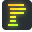

In [12]:
%%pyinstrument

drop_table(TABLE_NAME, db.connect())
insert(df, TABLE_NAME, db.connect(), primary_key="time")

* JSON is read differently by binary and pymonetdb due to a bug in pymonetdb (ignore `col_1_json`)


In [13]:
from utils import compare

In [14]:
drop = [n for n in df.columns if "json" in n]

In [15]:
df_pymonetdb = fetch_pymonetdb(f"select * from {TABLE_NAME} order by time", db.connect()).drop(drop, strict=False)

In [16]:
df_binary = fetch_binary(f"select * from {TABLE_NAME} order by time", db.connect()).drop(drop, strict=False)

In [17]:
compare(df_pymonetdb, df_binary)

✅ Checking DataFrames...
✅ DataFrames are completely equal!


In [18]:
compare(df_pymonetdb, df.drop(drop, strict=False).sort("time"))

✅ Checking DataFrames...
✅ DataFrames are completely equal!


In [19]:
compare(df_binary, df.drop(drop, strict=False).sort("time"))

✅ Checking DataFrames...
✅ DataFrames are completely equal!


In [20]:
df

time,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,…,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_1_int8,col_1_int16,col_1_int32,col_1_int64,col_1_float32,col_1_float64,col_1_decimal_default,col_1_decimal_14_5,col_1_decimal_10_2,col_1_str,col_1_bool,col_1_blob,col_1_json_string,col_1_json_obj,col_1_json_struct,time_time,time_date
datetime[ms],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,i32,i64,f32,f64,"decimal[18,3]","decimal[14,5]","decimal[10,2]",str,bool,binary,str,object,struct[1],time,date
2024-08-15 02:41:00,0.99439,0.655433,0.117288,0.11442,0.091383,0.797504,0.75722,0.527782,0.464873,0.592167,0.854792,0.210921,0.604031,0.081711,0.019506,0.706256,0.327759,0.218371,0.825249,0.884843,0.926574,0.718446,0.827058,0.980189,0.392664,0.436836,0.005624,0.752218,0.828335,0.480415,0.55338,0.802938,0.249983,0.703698,0.759349,0.504259,…,0.519513,0.692039,0.268861,0.806501,0.765445,0.797289,0.784079,0.409881,0.406423,0.636099,0.759247,0.968955,0.231726,0.999709,0.412795,0.590418,0.337381,0.401983,0.837193,0.988874,49,49,49,49,0.99439,0.99439,0.994,0.99438,0.99,"""0.99438983""",true,"b""0.99438983""","""{ ""val"": 0.99438983}""",{'val': 0.99438983},{0.99439},02:41:00,2024-08-15
2024-08-15 02:42:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:43:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:44:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2024-08-15 02:45:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-12-31 23:56:00,0.606382,0.833705,0.064703,0.4515,0.954778,0.5246,0.430437,0.218519,0.909367,0.756414,0.115018,0.848976,0.097597,0.295433,0.667968,0.346528,0.018431,0.084524,0.627159,0.616916,0.54549,0.44865,0.343535,0.393814,0.78895,0.889932,0.033777,0.632749,0.662151,0.821839,0.218898,0.280356,0.172431,0.485558,0.828015,0.174794,…,0.633961,0.717917,0.631814,0.177693,0.804182,0.326624,0.561434,0.073278,0.974752,0.022943,0.282813,0.316544,0.191472,0.640459,0.167137,0.842936,0.281187,0.988227,0.35858,0.042129,10,10,10,10,0.606382,0.606382,0.606,0.60638,0.60,"""0.60638154""",true,"b""0.60638154""",""